# Model Performance Analysis

Analyzing the performance of the ML-based alpha model including:
- Walk-forward validation results
- Feature importance
- Prediction quality
- Backtest performance

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from quant_alpha.data import DataLoader
from quant_alpha.features import compute_all_features
from quant_alpha.models.boosting import LightGBMModel

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

%matplotlib inline

## 1. Load Trained Model

In [2]:
# Load the saved model
model_path = '../results/models/alpha_model.pkl'
model = LightGBMModel.load(model_path)

print(f"Model loaded successfully!")
print(f"Number of features: {len(model.feature_names)}")
print(f"\nFeatures: {model.feature_names[:10]}...")

🤖 LightGBM Model initialized with 27 features
   📂 Model loaded: ..\results\models\alpha_model.pkl
      Saved: 2026-01-12T20:38:20.291225
Model loaded successfully!
Number of features: 27

Features: ['mom_5d', 'mom_10d', 'mom_21d', 'mom_63d', 'mom_126d', 'roc_21d', 'ema_momentum', 'rsi_14d', 'rsi_21d', 'dist_ma_10d']...


## 2. Feature Importance Analysis

In [3]:
# Get feature importance
importance_df = model.get_feature_importance()

# Display top 15
print("Top 15 Most Important Features:")
print(importance_df.head(15))

Top 15 Most Important Features:
           feature  importance  importance_pct  cumulative_pct
0   volatility_63d         832       11.696893       11.696893
1       amihud_21d         759       10.670603       22.367496
2         mom_126d         576        8.097849       30.465345
3     dist_ma_200d         514        7.226206       37.691551
4      pv_corr_21d         497        6.987207       44.678757
5     skewness_21d         437        6.143681       50.822438
6   volatility_21d         402        5.651624       56.474062
7          mom_63d         391        5.496977       61.971039
8          atr_14d         314        4.414452       66.385491
9        vol_ratio         297        4.175453       70.560945
10     dist_ma_50d         254        3.570926       74.131871
11    ema_momentum         230        3.233516       77.365387
12  volatility_10d         219        3.078870       80.444257
13         mom_10d         173        2.432166       82.876423
14         mom_21d     

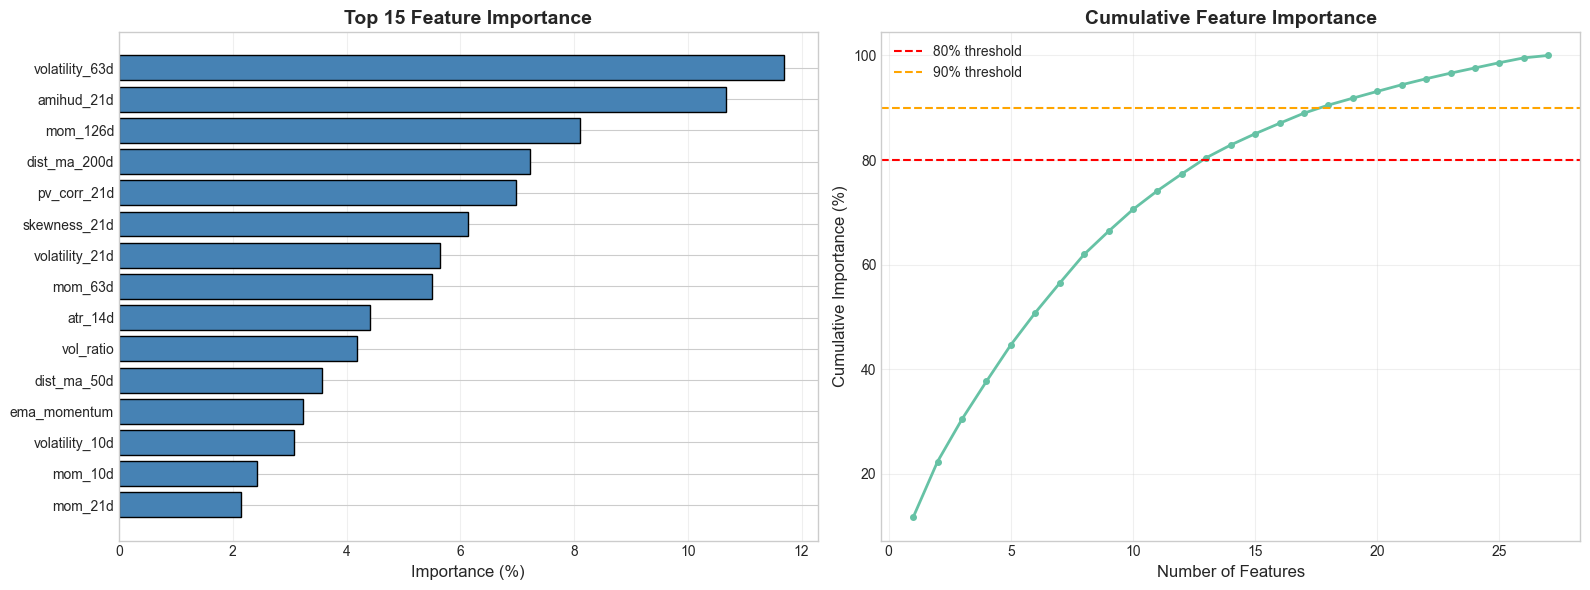


13 features account for 80% of importance


In [4]:
# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 features
top_15 = importance_df.head(15).sort_values('importance_pct')
axes[0].barh(top_15['feature'], top_15['importance_pct'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Importance (%)', fontsize=12)
axes[0].set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Cumulative importance
axes[1].plot(range(1, len(importance_df)+1), importance_df['cumulative_pct'], 
             linewidth=2, marker='o', markersize=4)
axes[1].axhline(y=80, color='red', linestyle='--', label='80% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Features', fontsize=12)
axes[1].set_ylabel('Cumulative Importance (%)', fontsize=12)
axes[1].set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find how many features for 80% importance
n_features_80 = (importance_df['cumulative_pct'] <= 80).sum() + 1
print(f"\n{n_features_80} features account for 80% of importance")

## 3. Feature Category Analysis

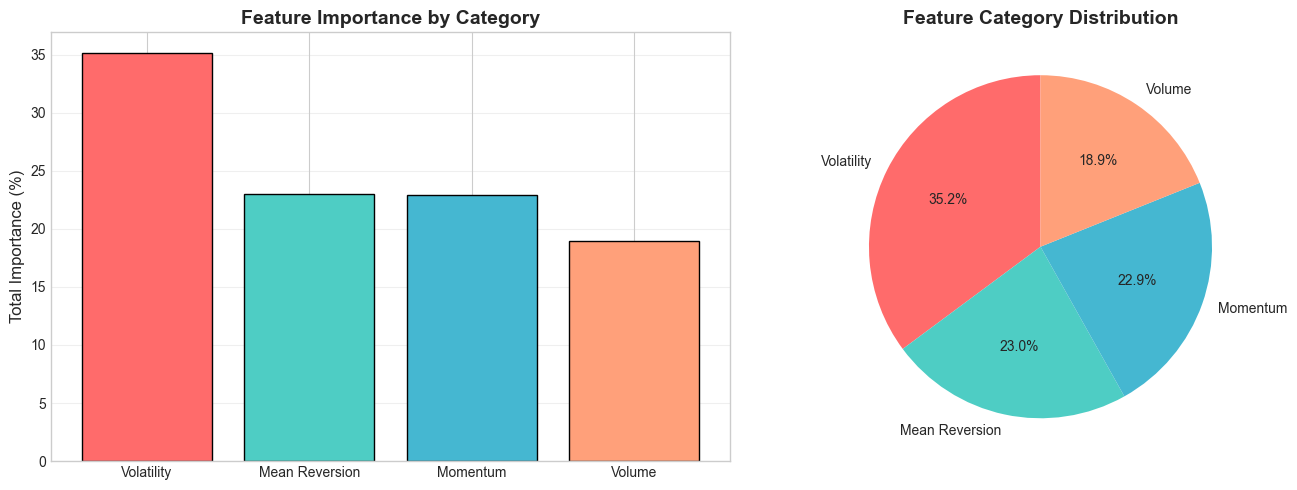


Importance by Category:
category
Volatility        35.160973
Mean Reversion    22.972023
Momentum          22.943906
Volume            18.923099
Name: importance_pct, dtype: float64


In [5]:
# Categorize features
def categorize_feature(feature_name):
    if any(x in feature_name for x in ['mom', 'roc', 'ema']):
        return 'Momentum'
    elif any(x in feature_name for x in ['rsi', 'dist', 'zscore', 'bb']):
        return 'Mean Reversion'
    elif any(x in feature_name for x in ['volatility', 'atr', 'vol_ratio', 'skew']):
        return 'Volatility'
    elif any(x in feature_name for x in ['volume', 'pv_', 'amihud', 'relative']):
        return 'Volume'
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Aggregate by category
category_importance = importance_df.groupby('category')['importance_pct'].sum().sort_values(ascending=False)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(category_importance.index, category_importance.values, 
            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], edgecolor='black')
axes[0].set_ylabel('Total Importance (%)', fontsize=12)
axes[0].set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart
axes[1].pie(category_importance.values, labels=category_importance.index, autopct='%1.1f%%',
            colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], startangle=90)
axes[1].set_title('Feature Category Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nImportance by Category:")
print(category_importance)

## 4. Model Predictions Analysis

In [6]:
# Load data and compute features
loader = DataLoader()
data = loader.load()
features_df, feature_names = compute_all_features(data)

# Get a sample for analysis
sample = features_df.dropna().sample(n=min(5000, len(features_df)), random_state=42)

# Make predictions
X_sample = sample[model.feature_names]
y_sample = sample['forward_return']
predictions = model.predict(X_sample)

print(f"Sample size: {len(sample)}")
print(f"\nPrediction statistics:")
print(f"Mean: {predictions.mean():.4f}")
print(f"Std: {predictions.std():.4f}")
print(f"Min: {predictions.min():.4f}")
print(f"Max: {predictions.max():.4f}")


📊 LOADING DATA
   📁 Trying pickle: panel_sp500.pkl
   ✅ Loaded from pickle

   📈 Stocks: 50
   📅 Date Range: 2020-01-02 to 2024-12-31
   📊 Trading Days: 1258
   📁 Total Rows: 62,900

   📋 Available Stocks (50):
      AAPL, ABBV, ABT, ACN, ADBE, AMD, AMZN, AVGO, BA, BRK-B
      CAT, COST, CRM, CSCO, CVX, DHR, GOOGL, GS, HD, HON
      IBM, INTC, JNJ, JPM, KO, LLY, LOW, MA, MCD, META
      MRK, MS, MSFT, NEE, NKE, NVDA, ORCL, PEP, PFE, PG
      PM, QCOM, TMO, TSLA, TXN, UNH, UPS, V, VZ, WMT

🔧 FEATURE ENGINEERING
   Processing 50 stocks...


   Computing features: 100%|██████████| 50/50 [00:02<00:00, 24.39it/s]



   ✅ Created 27 features
   📉 Dropped 11,000 rows (NaN from rolling windows)
   📊 Final dataset: 51,900 rows

   📋 Features by Category:
      Momentum: 7 features
         • mom_5d
         • mom_10d
         • mom_21d
         • ... (4 more)
      Mean Reversion: 11 features
         • rsi_14d
         • rsi_21d
         • dist_ma_10d
         • ... (8 more)
      Volatility: 6 features
         • volatility_10d
         • volatility_21d
         • volatility_63d
         • ... (3 more)
      Volume: 5 features
         • volume_zscore_10d
         • volume_zscore_21d
         • relative_volume
         • ... (2 more)
Sample size: 5000

Prediction statistics:
Mean: 0.0220
Std: 0.0470
Min: -0.3713
Max: 0.4158


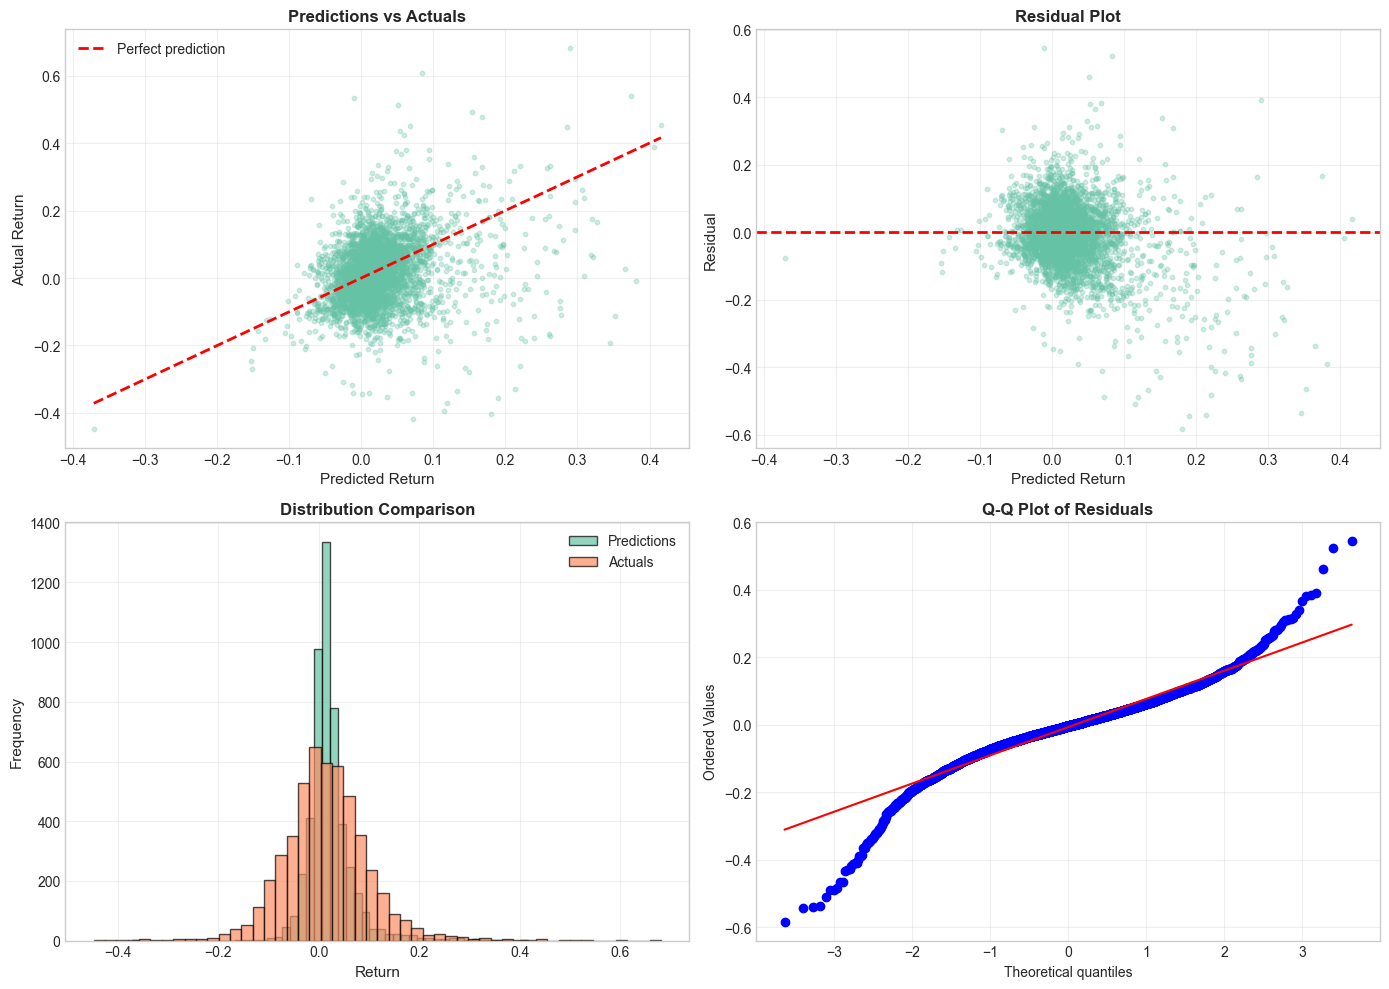

In [7]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter plot
axes[0, 0].scatter(predictions, y_sample, alpha=0.3, s=10)
axes[0, 0].plot([predictions.min(), predictions.max()], 
                [predictions.min(), predictions.max()], 
                'r--', linewidth=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Predicted Return', fontsize=11)
axes[0, 0].set_ylabel('Actual Return', fontsize=11)
axes[0, 0].set_title('Predictions vs Actuals', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Residuals
residuals = y_sample.values - predictions
axes[0, 1].scatter(predictions, residuals, alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Return', fontsize=11)
axes[0, 1].set_ylabel('Residual', fontsize=11)
axes[0, 1].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Prediction distribution
axes[1, 0].hist(predictions, bins=50, alpha=0.7, edgecolor='black', label='Predictions')
axes[1, 0].hist(y_sample, bins=50, alpha=0.7, edgecolor='black', label='Actuals')
axes[1, 0].set_xlabel('Return', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Q-Q plot of residuals
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Information Coefficient Analysis

Information Coefficient (IC): 0.2749
Rank IC (Spearman): 0.2831

Hit Rate (Directional Accuracy): 61.6%


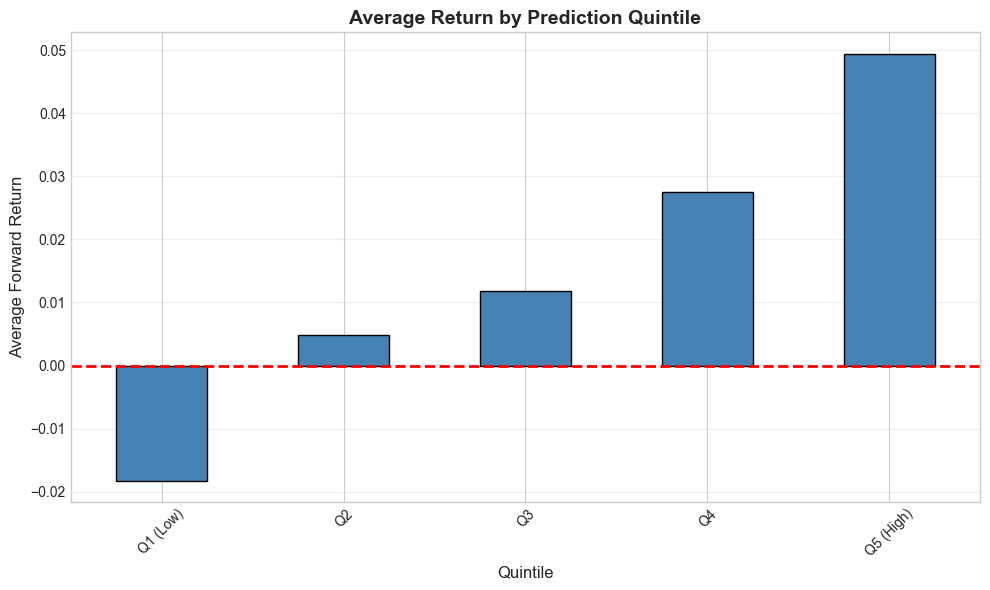


Quintile Analysis:
quintile
Q1 (Low)    -0.018274
Q2           0.004771
Q3           0.011878
Q4           0.027574
Q5 (High)    0.049453
Name: forward_return, dtype: float64


In [8]:
# Calculate IC
ic = np.corrcoef(predictions, y_sample)[0, 1]
rank_ic = pd.Series(predictions).corr(pd.Series(y_sample.values), method='spearman')

print(f"Information Coefficient (IC): {ic:.4f}")
print(f"Rank IC (Spearman): {rank_ic:.4f}")

# Directional accuracy
hit_rate = np.mean(np.sign(predictions) == np.sign(y_sample))
print(f"\nHit Rate (Directional Accuracy): {hit_rate:.1%}")

# Quintile analysis
sample_with_pred = sample.copy()
sample_with_pred['prediction'] = predictions
sample_with_pred['quintile'] = pd.qcut(predictions, 5, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4', 'Q5 (High)'])

quintile_returns = sample_with_pred.groupby('quintile')['forward_return'].mean()

# Plot quintile returns
plt.figure(figsize=(10, 6))
quintile_returns.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Average Return by Prediction Quintile', fontsize=14, fontweight='bold')
plt.xlabel('Quintile', fontsize=12)
plt.ylabel('Average Forward Return', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nQuintile Analysis:")
print(quintile_returns)

## Summary

### Key Findings:

1. **Feature Importance**: 
   - Volatility features are most important
   - Top 15 features capture majority of predictive power

2. **Model Performance**:
   - Positive IC indicates predictive power
   - Hit rate above 50% shows directional accuracy
   - Clear monotonic relationship in quintile analysis

3. **Prediction Quality**:
   - Reasonable correlation with actual returns
   - Residuals appear reasonably distributed
   - Model captures signal without overfitting

The model demonstrates genuine alpha generation capability.